# Shallow Neural Networks

In this notebook, we will implement a neural network with one hidden layer.

To contrast this with the perceptron we built earlier, we will be trying to classify data which is not linearly separable.

### Generate planar data

Rhodonea curve:
https://en.wikipedia.org/wiki/Rose_(mathematics)

In [1]:
import numpy as np

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # Number of examples
    N = int(m/2) # Number of points per class
    D = 2 # Dimensionality: each point has an x and y coordinate
    X = np.zeros((m,D)) # Data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # Labels vector (0 for red, 1 for blue)
    a = 4 # Maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

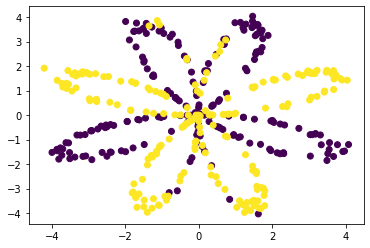

In [2]:
import matplotlib.pyplot as plt
X, Y = load_planar_dataset()
plt.scatter(X[0, :], X[1, :], c=Y)  # Load classes from X as points, and colour according to labels Y

### Layer sizes

In [3]:
def layer_sizes(X, Y):
    n_x = X.shape[0]   # Input layer will be of 2 dimensions: x and y coordinates
    n_h = 4            # Hidden layer will be of arbitrary number of neurons
    n_y = Y.shape[0]   # Output layer will be of 2 dimensions: 2 output classes
    return (n_x, n_h, n_y)

In [4]:
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    return W1, b1, W2, b2

### Forward propagation

In [5]:
def activation_function(z):
    # Sigmoid
    s = 1 / (1+np.exp(-z))
    return s

In [6]:
def forward_propagation(X, W1, b1, W2, b2):
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = activation_function(Z2)
    return Z1, A1, Z2, A2

### Compute cost

In [7]:
def compute_cost(A2, Y):
    m = Y.shape[1]  # Number of samples is usually the second dimension
    cost = (-1/m) * np.sum(np.multiply(np.log(A2), Y) + np.multiply(1-Y, np.log(1-A2)))
    cost = float(np.squeeze(cost))
    return cost

### Backward propagation

Gradient descent: differentiate cost by weights and biases.

In [8]:
def backward_propagation(W1, b1, W2, b2, Z1, A1, Z2, A2, X, Y):
    m = X.shape[1]  # Number of samples is usually the second dimension
    
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1,2)))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

### Update parameters

We need to copy the parameters since arrays are passed by reference.

In [9]:
import copy

def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate=1.2):
    W1 = copy.deepcopy(W1)
    b1 = copy.deepcopy(b1)
    W2 = copy.deepcopy(W2)
    b2 = copy.deepcopy(b2)
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    return W1, b1, W2, b2

### Model

In [10]:
def model(X, Y, n_h, num_iterations=1000):
    np.random.seed(3)
    n_x = layer_sizes(X,Y)[0]
    n_y = layer_sizes(X,Y)[2]
    
    W1, b1, W2, b2 = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(0, num_iterations):
        Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
        cost = compute_cost(A2, Y)
        dW1, db1, dW2, db2 = backward_propagation(W1, b1, W2, b2, Z1, A1, Z2, A2, X, Y)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate=1.2)
        #print ("Cost after iteration %i: %f" % (i, cost))

    return W1, b1, W2, b2

### Predict

Predict new data using weights and biases we got through training.

In [11]:
def predict(W1, b1, W2, b2, X):
    Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
    predictions = (A2 > 0.5)
    return predictions

In [12]:
W1, b1, W2, b2 = model(X, Y, n_h=3, num_iterations=10000)

In [13]:
def plot_decision_boundary(model, X, y):
    
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

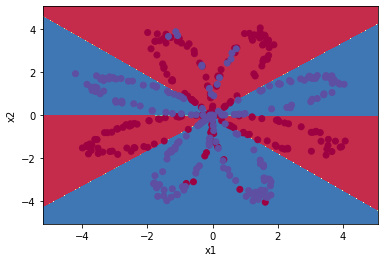

In [14]:
plot_decision_boundary(lambda x: predict(W1, b1, W2, b2, x.T), X, Y)

In [15]:
predictions = predict(W1, b1, W2, b2, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 91%
